In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn ydata-profiling sweetviz autoviz dtale pycaret


  Using cached scikit_learn-1.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)


In [ ]:
!kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data -p /content/airbnb_data --unzip


Dataset URL: https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data
License(s): CC0-1.0
100% 2.44M/2.44M [00:00<00:00, 4.65MB/s]
100% 2.44M/2.44M [00:00<00:00, 3.98MB/s]


In [ ]:
# Import Libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, IsolationForest, VotingRegressor)
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
import sweetviz as sv
from autoviz.AutoViz_Class import AutoViz_Class
import warnings
warnings.filterwarnings('ignore')
from pycaret.regression import *

In [ ]:
# Load and Perform Initial EDA

def load_and_analyze_airbnb_data(file_path):
    """
    Load Airbnb data and perform initial EDA
    """
    print("Loading data and performing EDA...")

    # Load data
    df = pd.read_csv(file_path)

    # Basic information
    print("\nBasic Dataset Information:")
    print("-" * 50)
    print("Shape:", df.shape)
    print("\nColumns:", df.columns.tolist())
    print("\nData Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())

    # Basic statistics
    print("\nNumerical Statistics:")
    print(df.describe())

    return df

# Load the data
airbnb_df = load_and_analyze_airbnb_data('/content/airbnb_data/AB_NYC_2019.csv')


Loading data and performing EDA...

Basic Dataset Information:
--------------------------------------------------
Shape: (48895, 16)

Columns: ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

Data Types:
 id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64



Creating initial visualizations...


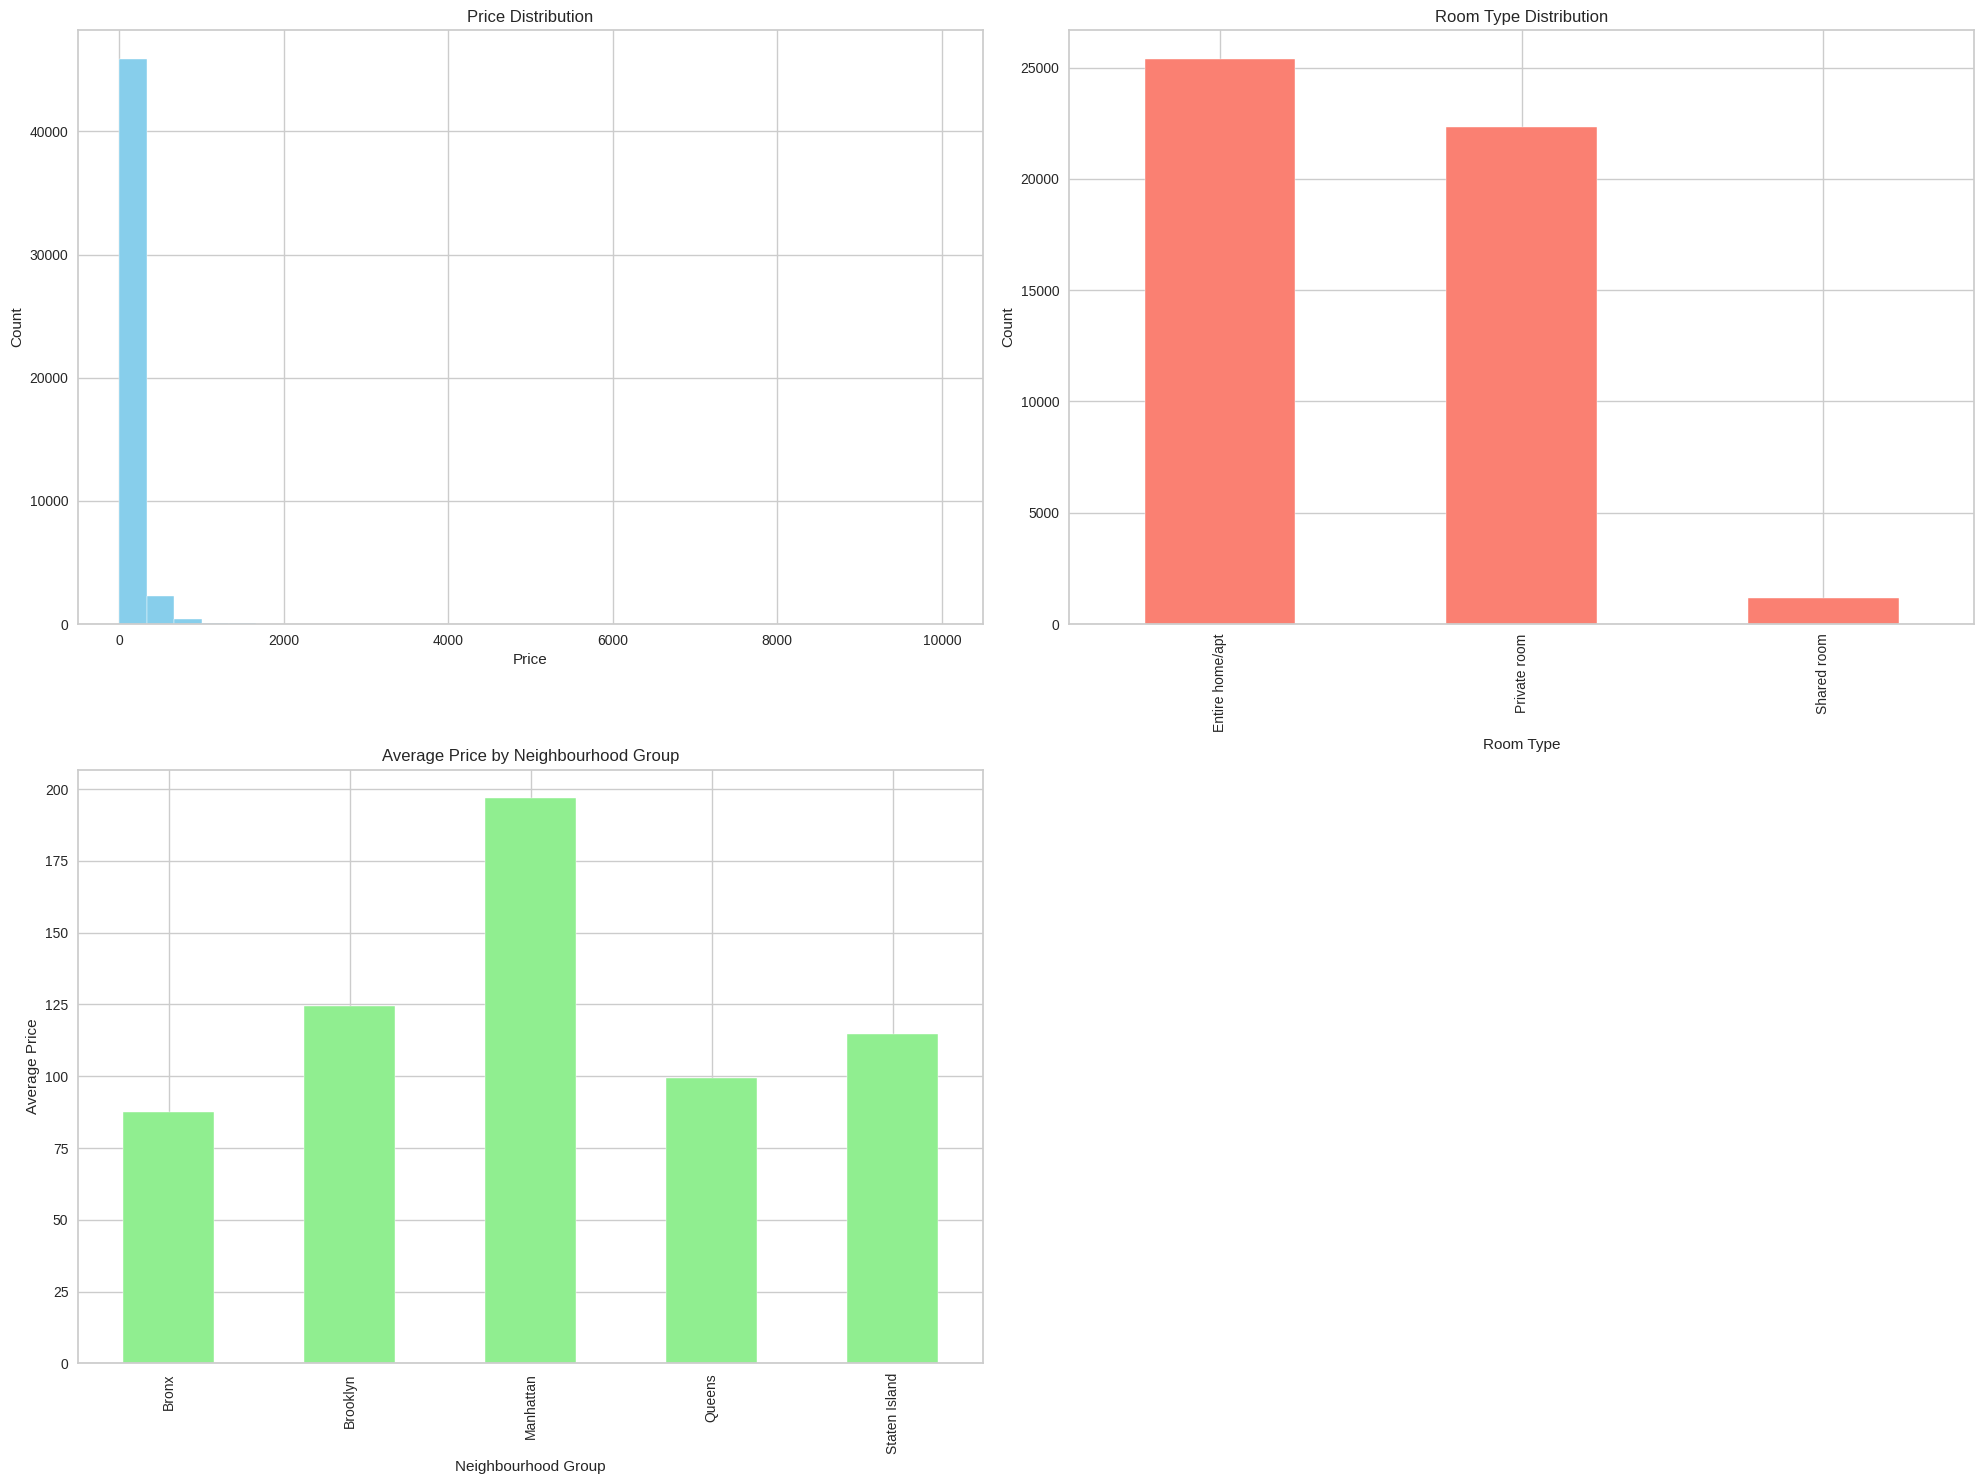

In [ ]:
def create_initial_visualizations(df):
    """
    Create initial visualization set
    """
    print("\nCreating initial visualizations...")

    # Set up the figure
    plt.figure(figsize=(20, 15))

    # 1. Price distribution
    plt.subplot(2, 2, 1)
    plt.hist(df['price'], bins=30, color='skyblue')
    plt.title('Price Distribution')
    plt.xlabel('Price')
    plt.ylabel('Count')

    # 2. Room type distribution
    plt.subplot(2, 2, 2)
    df['room_type'].value_counts().plot(kind='bar', color='salmon')
    plt.title('Room Type Distribution')
    plt.xlabel('Room Type')
    plt.ylabel('Count')

    # 3. Average price by neighbourhood group
    plt.subplot(2, 2, 3)
    df.groupby('neighbourhood_group')['price'].mean().plot(kind='bar', color='lightgreen')
    plt.title('Average Price by Neighbourhood Group')
    plt.xlabel('Neighbourhood Group')
    plt.ylabel('Average Price')

    plt.tight_layout()
    plt.show()

# Create visualizations
create_initial_visualizations(airbnb_df)

In [ ]:
def preprocess_airbnb_data(df):
    """
    Preprocess Airbnb data with consistent column naming and encoding.
    """
    print("\nStarting data preprocessing...")

    # Standardize column names to replace spaces with underscores
    df.columns = df.columns.str.replace(" ", "_")

    # Drop irrelevant columns if they exist
    columns_to_drop = ['id', 'name', 'host_name', 'last_review']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

    # Fill missing values for 'reviews_per_month' if it exists
    if 'reviews_per_month' in df.columns:
        df['reviews_per_month'].fillna(0, inplace=True)

    # Replace spaces with underscores in categorical values
    df['neighbourhood_group'] = df['neighbourhood_group'].str.replace(" ", "_")
    df['room_type'] = df['room_type'].str.replace(" ", "_")

    # Apply OneHotEncoding to categorical features with consistent naming
    column_transformer = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first'), ['neighbourhood_group', 'room_type'])
        ],
        remainder='passthrough'
    )

    # Fit and transform the data
    df_encoded = pd.DataFrame(column_transformer.fit_transform(df), columns=column_transformer.get_feature_names_out())

    # Remove prefixes from column names
    df_encoded.columns = [col.split("__")[-1] for col in df_encoded.columns]

    # Set the DataFrame index to match the original
    df_encoded.index = df.index

    # Log-transform the price variable if it exists
    if 'price' in df.columns:
        df_encoded['price'] = np.log1p(df['price'].values)

    # Scale numerical features if they exist in the DataFrame
    num_cols = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month']
    scaler = RobustScaler()
    df_encoded[num_cols] = scaler.fit_transform(df[num_cols])

    print("\nTransformed Column Names (After Removing Prefixes):")
    print(df_encoded.columns.tolist())

    return df_encoded


airbnb_df_preprocessed = preprocess_airbnb_data(airbnb_df)



Starting data preprocessing...

Transformed Column Names (After Removing Prefixes):
['neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten_Island', 'room_type_Private_room', 'room_type_Shared_room', 'host_id', 'neighbourhood', 'latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


In [ ]:
# Show the first few rows of the original DataFrame
print("\nOriginal DataFrame Sample:")
print(airbnb_df.head())

# Show the first few rows of the transformed DataFrame
print("\nTransformed DataFrame Sample:")
# Assign the result of preprocess_airbnb_data to a variable
airbnb_df_preprocessed = preprocess_airbnb_data(airbnb_df)
# Use the assigned variable to print the head
print(airbnb_df_preprocessed.head())


Original DataFrame Sample:
    id                         name                        host_id  \
0  2539                Clean & quiet apt home by the park   2787     
1  2595                             Skylit Midtown Castle   2845     
2  3647               THE VILLAGE OF HARLEM....NEW YORK !   4632     
3  3831                   Cozy Entire Floor of Brownstone   4869     
4  5022  Entire Apt: Spacious Studio/Loft by central park   7192     

   host_name   neighbourhood_group neighbourhood  latitude  longitude  \
0         John        Brooklyn        Kensington  40.64749 -73.97237    
1     Jennifer       Manhattan           Midtown  40.75362 -73.98377    
2    Elisabeth       Manhattan            Harlem  40.80902 -73.94190    
3  LisaRoxanne        Brooklyn      Clinton Hill  40.68514 -73.95976    
4        Laura       Manhattan       East Harlem  40.79851 -73.94399    

     room_type      price  minimum_nights  number_of_reviews last_review  \
0     Private room   149          1 

In [ ]:
# Clustering and Anomaly Detection

def perform_clustering(df):
    """
    Perform clustering and anomaly detection on Airbnb data
    """
    print("\nPerforming clustering and anomaly detection...")

    # Select features for clustering
    cluster_features = ['latitude', 'longitude', 'price', 'minimum_nights']
    X = df[cluster_features].copy()

    # Scale features
    X_scaled = StandardScaler().fit_transform(X)

    # Apply K-means clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    df['cluster'] = kmeans.fit_predict(X_scaled)

    # Anomaly detection
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    df['is_anomaly'] = iso_forest.fit_predict(X_scaled)
    df['is_anomaly'] = df['is_anomaly'].map({1: 0, -1: 1})  # 1 for anomaly

    return df

# Perform clustering and anomaly detection
airbnb_df_clustered = perform_clustering(airbnb_df_preprocessed)




Performing clustering and anomaly detection...


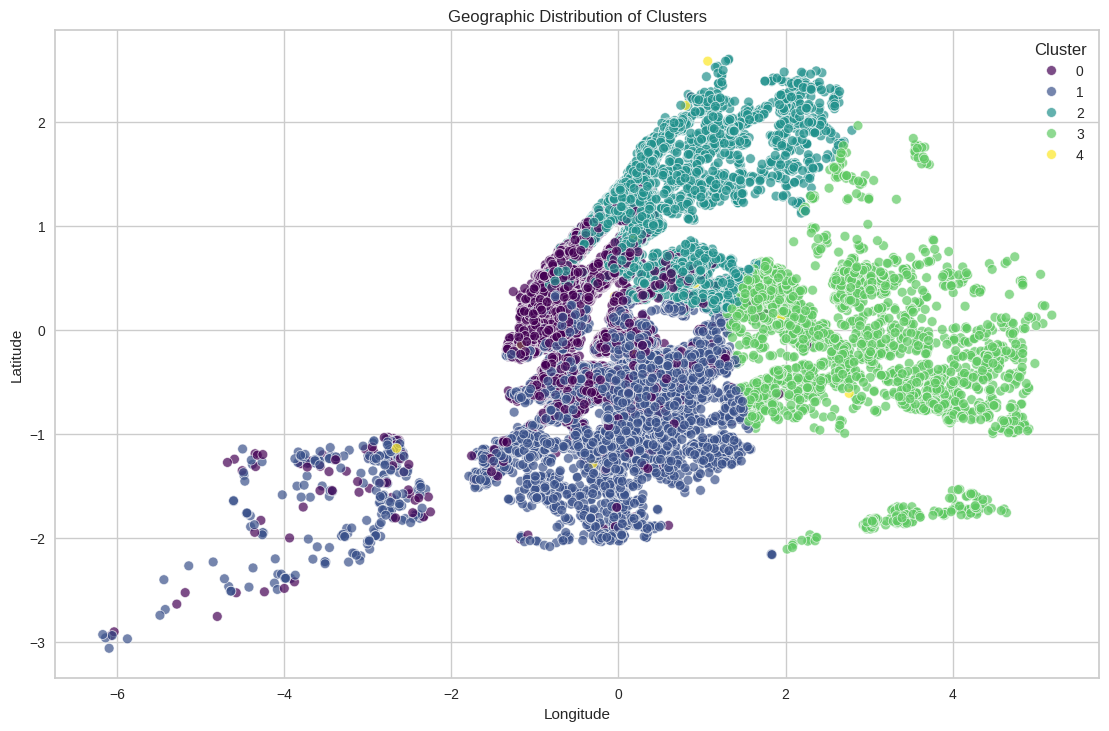

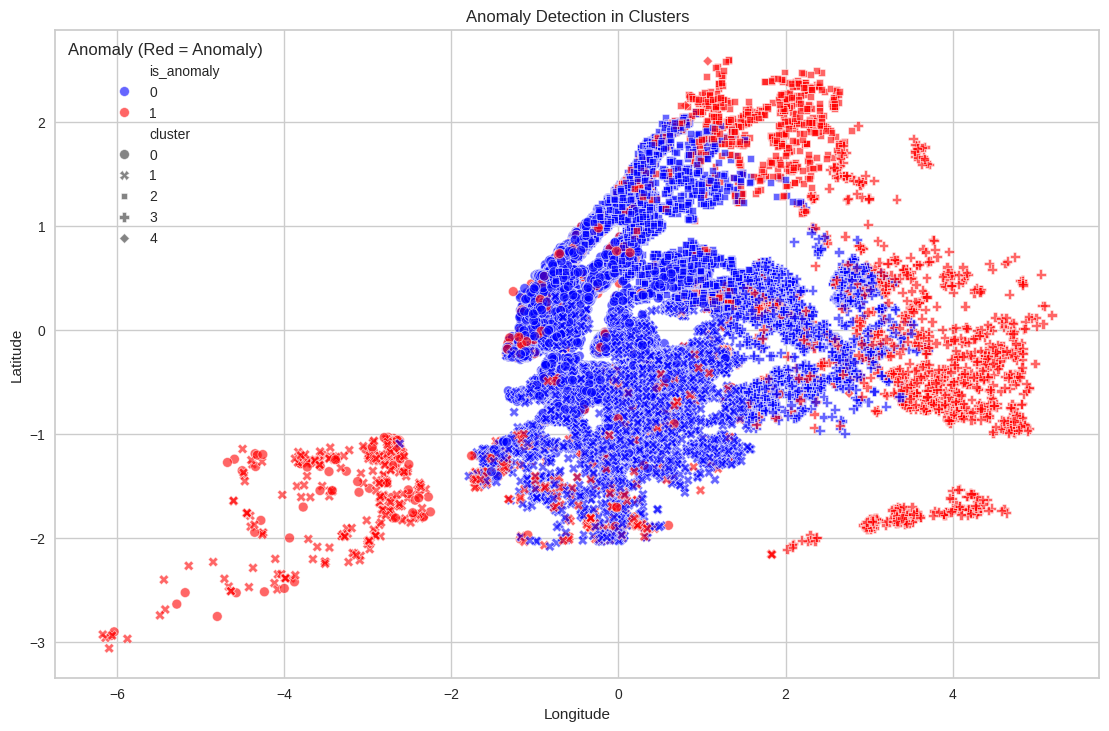

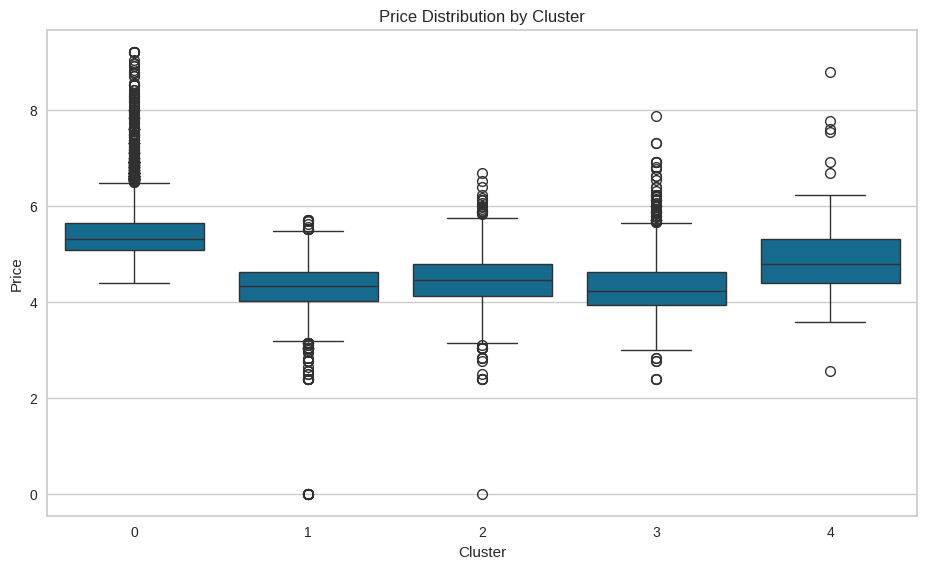

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter Plot of Clusters
def plot_clusters(df):
    """
    Visualize clusters on a scatter plot.
    """
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x='longitude', y='latitude',
        hue='cluster',
        data=df,
        palette='viridis',
        s=50,
        alpha=0.7
    )
    plt.title("Geographic Distribution of Clusters")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(title="Cluster")
    plt.show()

# Scatter Plot with Anomalies
def plot_anomalies(df):
    """
    Visualize anomalies within clusters.
    """
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x='longitude', y='latitude',
        hue='is_anomaly',
        style='cluster',
        data=df,
        palette={0: 'blue', 1: 'red'},  # Red for anomalies
        s=50,
        alpha=0.6
    )
    plt.title("Anomaly Detection in Clusters")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(title="Anomaly (Red = Anomaly)")
    plt.show()

# Box Plot of Price by Cluster
def plot_price_by_cluster(df):
    """
    Plot a boxplot of price by cluster.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y='price', data=df)
    plt.title("Price Distribution by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Price")
    plt.show()

# Run all three plots in one cell
plot_clusters(airbnb_df_clustered)
plot_anomalies(airbnb_df_clustered)
plot_price_by_cluster(airbnb_df_clustered)


In [ ]:
# Prepare Data for AutoML

def prepare_data_for_automl(df):
    """
    Prepare data for AutoML with proper scaling
    """
    print("Preparing data for AutoML...")

    # Define X and y for AutoML
    X = df.drop(['price'], axis=1)
    y = df['price']

    return X, y

X, y = prepare_data_for_automl(airbnb_df_clustered)

Preparing data for AutoML...


In [ ]:
# Automated Machine Learning (AutoML) with PyCaret

def run_automl_with_pycaret(X, y):
    """
    Run AutoML pipeline using PyCaret for Airbnb data
    """
    # Combine X and y to create a full dataset for PyCaret
    df_combined = pd.concat([X, y], axis=1)

    print("Setting up AutoML environment with PyCaret...")
    setup(data=df_combined, target='price', train_size=0.8, session_id=42, preprocess=True, feature_selection=True)

    print("\nComparing models...")
    best_model = compare_models(n_select=3)

    print("\nTuning top models...")
    tuned_models = [tune_model(model) for model in best_model]

    print("\nBlending top models for ensemble...")
    ensemble_model = blend_models(tuned_models)

    print("\nFinalizing model...")
    final_model = finalize_model(ensemble_model)

    return final_model


# Run AutoML with PyCaret
final_model = run_automl_with_pycaret(X, y)

Setting up AutoML environment with PyCaret...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1852
[LightGBM] [Info] Number of data points in the train set: 39116, number of used features: 17
[LightGBM] [Info] Start training from score 4.739563


,Description,Value
0,Session id,42
1,Target,price
2,Target type,Regression
3,Original data shape,"(48895, 18)"
4,Transformed data shape,"(48895, 4)"
5,Transformed train set shape,"(39116, 4)"
6,Transformed test set shape,"(9779, 4)"
7,Numeric features,7
8,Categorical features,10
9,Preprocess,True



Comparing models...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.4575,0.3797,0.6161,0.2186,0.1070,0.0965,1.4120
gbr,Gradient Boosting Regressor,0.4590,0.3798,0.6161,0.2185,0.1072,0.0969,2.8060
catboost,CatBoost Regressor,0.4572,0.3799,0.6162,0.2183,0.1073,0.0964,7.4560
knn,K Neighbors Regressor,0.4604,0.3814,0.6175,0.2151,0.1072,0.0970,0.9890
xgboost,Extreme Gradient Boosting,0.4578,0.3815,0.6176,0.2149,0.1078,0.0965,2.6800
rf,Random Forest Regressor,0.4629,0.3912,0.6253,0.1950,0.1088,0.0974,6.5760
ada,AdaBoost Regressor,0.4829,0.4023,0.6342,0.1719,0.1104,0.1022,1.4390
et,Extra Trees Regressor,0.4707,0.4049,0.6362,0.1667,0.1115,0.0994,3.0610
omp,Orthogonal Matching Pursuit,0.5102,0.4369,0.6609,0.1009,0.1155,0.1089,0.8060
ridge,Ridge Regression,0.5246,0.4515,0.6718,0.0707,0.1163,0.1105,0.8120


Processing:   0%|          | 0/87 [00:00<?, ?it/s]


Tuning top models...


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4456,0.3430,0.5857,0.2592,0.1000,0.0946
1,0.4457,0.3572,0.5977,0.2583,0.1019,0.0947
2,0.4451,0.3451,0.5874,0.2638,0.1004,0.0947
3,0.4541,0.3833,0.6191,0.2458,0.1128,0.0964
4,0.4475,0.3521,0.5933,0.2927,0.1070,0.0951
5,0.4391,0.3427,0.5854,0.2714,0.1029,0.0936
6,0.4551,0.3662,0.6051,0.2499,0.1026,0.0962
7,0.4489,0.3661,0.6051,0.2561,0.1078,0.0944
8,0.4604,0.3834,0.6192,0.2517,0.1049,0.0975


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4582,0.3687,0.6072,0.2037,0.1035,0.0968
1,0.4557,0.3771,0.6141,0.2170,0.1047,0.0965
2,0.4594,0.3695,0.6078,0.2118,0.1041,0.0970
3,0.4594,0.3932,0.6271,0.2263,0.1134,0.0971
4,0.4538,0.3671,0.6059,0.2625,0.1089,0.0962
5,0.4444,0.3537,0.5947,0.2480,0.1046,0.0944
6,0.4589,0.3778,0.6146,0.2261,0.1043,0.0969
7,0.4622,0.3905,0.6249,0.2065,0.1107,0.0967
8,0.4669,0.4014,0.6336,0.2166,0.1076,0.0985


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4604,0.3720,0.6099,0.1966,0.1038,0.0967
1,0.4585,0.3806,0.6170,0.2097,0.1050,0.0968
2,0.4604,0.3696,0.6079,0.2116,0.1037,0.0970
3,0.4620,0.3982,0.6311,0.2164,0.1144,0.0973
4,0.4587,0.3738,0.6114,0.2490,0.1095,0.0964
5,0.4492,0.3621,0.6018,0.2301,0.1054,0.0945
6,0.4624,0.3828,0.6187,0.2158,0.1048,0.0972
7,0.4665,0.3938,0.6275,0.1998,0.1112,0.0974
8,0.4716,0.4072,0.6381,0.2054,0.1079,0.0990


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 35204, number of used features: 17
[LightGBM] [Info] Start training from score 4.739795
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 35204, number of used features: 17
[LightGBM] [Info] Start training from score 4.740864
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007308 seconds.
You can set `force_ro

Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

Blending top models for ensemble...


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4507,0.3561,0.5967,0.2309,0.1018,0.0954
1,0.4499,0.3674,0.6061,0.2372,0.1034,0.0954
2,0.4520,0.3572,0.5977,0.2379,0.1023,0.0957
3,0.4550,0.3869,0.6221,0.2387,0.1130,0.0963
4,0.4489,0.3589,0.5991,0.2790,0.1079,0.0953
5,0.4401,0.3478,0.5898,0.2605,0.1037,0.0935
6,0.4556,0.3716,0.6096,0.2389,0.1034,0.0962
7,0.4556,0.3790,0.6157,0.2298,0.1093,0.0955
8,0.4633,0.3944,0.6280,0.2303,0.1065,0.0978


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 35204, number of used features: 3
[LightGBM] [Inf


Finalizing model...
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Info] Auto-choosing col-wise multi-threading


Evaluating the final model...


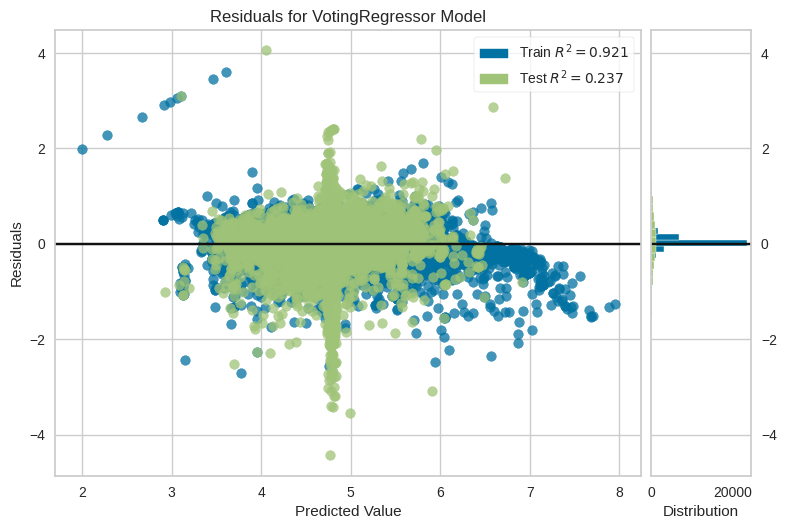

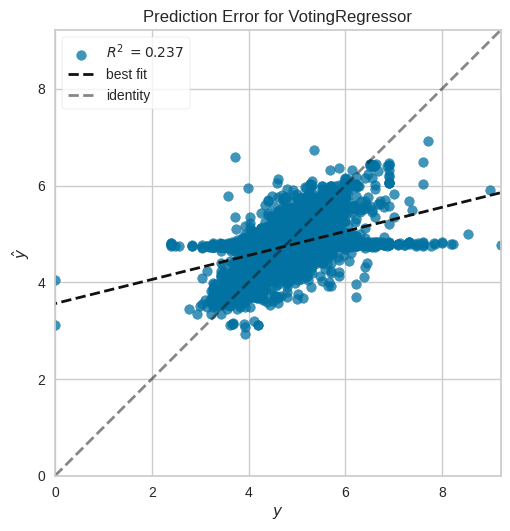

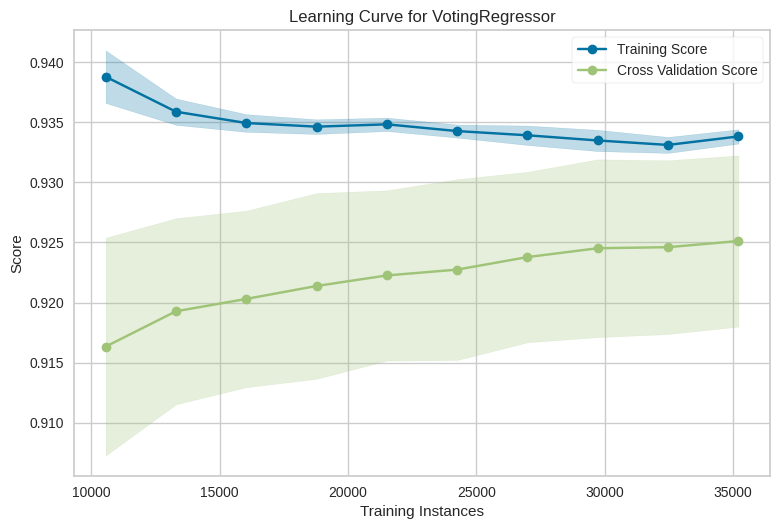

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
# Evaluate the model's performance on the test set
print("\nEvaluating the final model...")
plot_model(final_model, plot='residuals')       # Residuals plot
plot_model(final_model, plot='error')           # Error plot
plot_model(final_model, plot='learning')        # Learning curve

# Additional performance metrics (optional)
evaluate_model(final_model)
